In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'ibrahimelsayed25'
os.environ['KAGGLE_KEY'] = "01df320c0ba010cb1c6ff4314c310a57"

In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 710M/714M [00:21<00:00, 30.1MB/s]
100% 714M/714M [00:21<00:00, 34.3MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from glob import glob

from utils import *
from datagen import *
from config import *
from model import *

In [5]:
image_filenames = []
mask_filenames = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')
for item in mask_filenames:
  image_filenames.append(item.replace('_mask',''))

In [6]:
data_img_mask = pd.DataFrame(data = {'img_path': image_filenames,  'mask_path':mask_filenames})
data_img_mask.head(6)

,img_path,mask_path
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
5,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


/content/utils.py:32: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  result_image = color.label2rgb(mask_gray, np.array(img_gray)/np.array(img_gray).max())


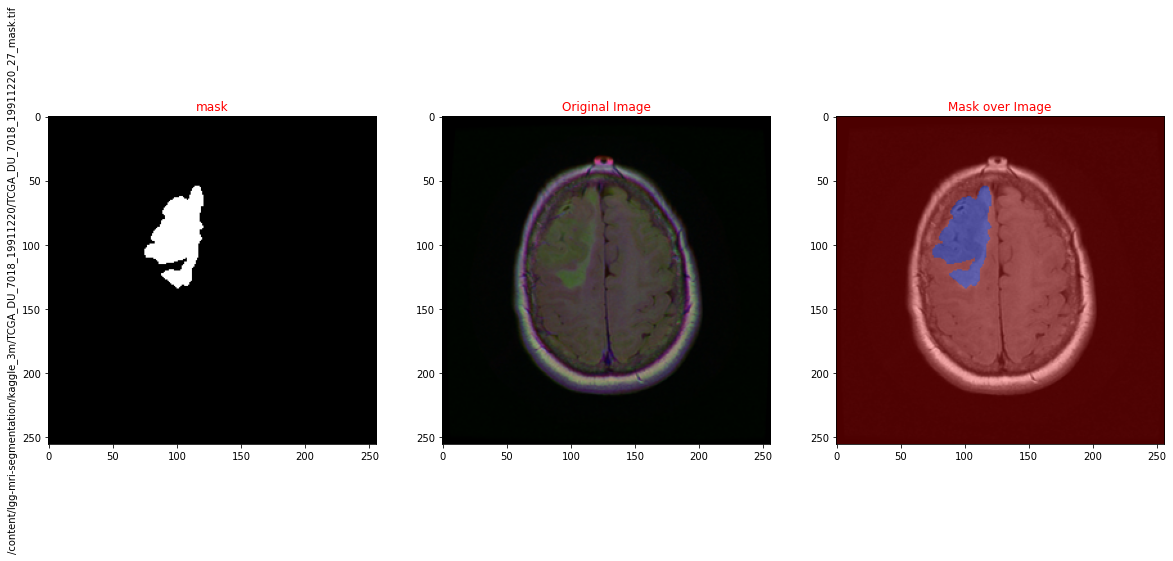

In [7]:
plot_image_mask_path(data_img_mask['img_path'].iloc[20],data_img_mask['mask_path'].iloc[20] )

In [8]:
data_train, data_test = train_test_split(data_img_mask, test_size = 0.1)

data_train, data_valid = train_test_split(data_train, test_size = 0.2)

In [9]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(2828, 2)
(708, 2)
(393, 2)


In [10]:
train_params = dict(rotation_range = 0.2,
                    width_shift_range = 0.05,
                    height_shift_range = 0.05,
                    shear_range = 0.05,
                    zoom_range = 0.05,
                    horizontal_flip = True,
                    fill_mode = 'nearest')

train_gen = data_generator(data_train, batch_size = BATCH_SIZE, augmentation = train_params,target_size = (im_height, im_width))
valid_gen = data_generator(data_valid, batch_size = BATCH_SIZE, augmentation= dict(), target_size = (im_height, im_width))


In [11]:
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model = unet_model(input_size=(im_height, im_width,3))

decay_rate = learning_rate / EPOCHS

opt = Adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999, decay = decay_rate, amsgrad = False)

model.compile(optimizer= opt, loss = dice_coefficients_loss, metrics = ['binary_accuracy', iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit( train_gen,
                    steps_per_epoch = len(data_train) / BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = valid_gen,
                    validation_steps = len(data_valid)/ BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: 0s - loss: -0.0209 - binary_accuracy: 0.5529 - iou: 0.0105 - dice_coefficients: 0.0208Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01934, saving model to unet.hdf5
88/88 [==============================] - 192s 2s/step - loss: -0.0209 - binary_accuracy: 0.5529 - iou: 0.0105 - dice_coefficients: 0.0208 - val_loss: -0.0193 - val_binary_accuracy: 0.0840 - val_iou: 0.0096 - val_dice_coefficients: 0.0189
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: -0.0220 - binary_accuracy: 0.5662 - iou: 0.0112 - dice_coefficients: 0.0219
Epoch 2: val_loss did not improve from -0.01934
88/88 [==============================] - 140s 2s/step - loss: -0.0220 - binary_accuracy: 0.5662 - iou: 0.0112 - dice_coefficients: 0.0219 - val_loss: -0.0187 - val_binary_accuracy: 0.1714 - val_iou: 

In [ ]:
history_training = history.history

train_dice_coeff_list = history.history_post_training['dice_coefficients']
test_dice_coeff_list = history.history_post_training['dice_coefficients']

train_jaccard_list = history_training['iou']
test_jaccard_list = history_training['val_iou']

train_loss_list = history_training['loss']
test_loss_list = history_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list,'b-')
plt.plot(train_loss_list, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list , 'r-')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [ ]:
test_gen = data_generator(data_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(data_test)/BATCH_SIZE)

In [ ]:
for i in range(20):
  index = np.random.ranint(1, len(data_test.index))
  img = cv2.imread(data_test['image_filenames'].iloc[index])
  img = cv2.resize(img, (im_height, im_width))
  img = img/255
  img = img[np.newaxis, :, :, :] # (1,255,255,3)
  predicted_img = model.predict(img)
  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(cv2.imread(data_test['mask_path'].iloc[index])))
  plt.title('Original Mask')
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(predicted_img) > 0.5)
  plt.title('Prediction')
  plt.show()